In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import gzip
from io import StringIO
import os
plt.style.use('ggplot')

%matplotlib inline

In [2]:
def parse_header_of_csv(csv_str):
    # Isolate the headline columns:
    headline = csv_str[:csv_str.index('\n')];
    columns = headline.split(',');

    # The first column should be timestamp:
    assert columns[0] == 'timestamp';
    # The last column should be label_source:
    assert columns[-1] == 'label_source';
    
    # Search for the column of the first label:
    for (ci,col) in enumerate(columns):
        if col.startswith('label:'):
            first_label_ind = ci;
            break;
        pass;

    # Feature columns come after timestamp and before the labels:
    feature_names = columns[1:first_label_ind];
    # Then come the labels, till the one-before-last column:
    label_names = columns[first_label_ind:-1];
    for (li,label) in enumerate(label_names):
        # In the CSV the label names appear with prefix 'label:', but we don't need it after reading the data:
        assert label.startswith('label:');
        label_names[li] = label.replace('label:','');
        pass;
    
    return (feature_names,label_names);

def parse_body_of_csv(csv_str,n_features):
    # Read the entire CSV body into a single numeric matrix:
    full_table = np.loadtxt(StringIO(csv_str),delimiter=',',skiprows=1);
    
    # Timestamp is the primary key for the records (examples):
    timestamps = full_table[:,0].astype(int);
    
    # Read the sensor features:
    X = full_table[:,1:(n_features+1)];
    
    # Read the binary label values, and the 'missing label' indicators:
    trinary_labels_mat = full_table[:,(n_features+1):-1]; # This should have values of either 0., 1. or NaN
    M = np.isnan(trinary_labels_mat); # M is the missing label matrix
    Y = np.where(M,0,trinary_labels_mat) > 0.; # Y is the label matrix
    
    return (X,Y,M,timestamps);

'''
Read the data (precomputed sensor-features and labels) for a useuuid = '1155FF54-63D3-4AB2-9863-8385D0BD0A13';
(X,Y,M,timestamps,feature_names,label_names) = read_user_data(uuid);r.
This function assumes the user's data file is present.
'''
def read_user_data(uuid):
    user_data_file = '%s.features_labels.csv' % uuid;

    # Read the entire csv file of the user:
#     with gzip.open(user_data_file,'rb') as fid:
#         csv_str = fid.read();
#         pass;
    with open(user_data_file,'r') as f:
        csv_str = f.read()
        
    (feature_names,label_names) = parse_header_of_csv(csv_str);
    n_features = len(feature_names);
    (X,Y,M,timestamps) = parse_body_of_csv(csv_str,n_features);

    return (X,Y,M,timestamps,feature_names,label_names);

In [3]:
os.chdir("/Users/panziqi/msds/MSDS697/project/sensor/data/ExtraSensory")
uuid = '00EABED2-271D-49D8-B599-1D4A09240601';
(X,Y,M,timestamps,feature_names,label_names) = read_user_data(uuid);

In [4]:
print("Every example has its timestamp, indicating the minute when the example was recorded")
print("User %s has %d examples (~%d minutes of behavior)" % (uuid,len(timestamps),len(timestamps)))
timestamps.shape

Every example has its timestamp, indicating the minute when the example was recorded
User 00EABED2-271D-49D8-B599-1D4A09240601 has 2287 examples (~2287 minutes of behavior)


(2287,)

In [5]:
M

array([[False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [6]:
print("The primary data files have %d different sensor-features" % len(feature_names))

The primary data files have 225 different sensor-features


In [7]:
print("X is the feature matrix. Each row is an example and each column is a sensor-feature:")
X.shape

X is the feature matrix. Each row is an example and each column is a sensor-feature:


(2287, 225)

In [8]:
print("The primary data files have %s context-labels" % len(label_names))

The primary data files have 51 context-labels


In [9]:
print("Y is the binary label-matrix. Each row represents an example and each column represents a label.")
print("Value of 1 indicates the label is relevant for the example:")
Y.shape

Y is the binary label-matrix. Each row represents an example and each column represents a label.
Value of 1 indicates the label is relevant for the example:


(2287, 51)

In [10]:
print("Y is accompanied by the missing-label-matrix, M.")
print("Value of 1 indicates that it is best to consider an entry (example-label pair) as 'missing':")
M.shape

Y is accompanied by the missing-label-matrix, M.
Value of 1 indicates that it is best to consider an entry (example-label pair) as 'missing':


(2287, 51)

====================================================================================================


The labels:

In [11]:
n_examples_per_label = np.sum(Y,axis=0);
n_examples_per_label

array([ 657, 1106,  163,    0,    0,  477,    0,  214,  306,  197, 1284,
          0,    0,   49,    0,    0,  995,    0,    0,    0,   55,   19,
          0,    0,   15,   38,    0,    0,    2,    0,    0,    0,    0,
          0,    0,   89,   54,    0,    0,   17,    0,    0,    0,    0,
        193,    0,    0,    0, 1594,  331,    0])

In [12]:
labels_and_counts = zip(label_names,n_examples_per_label);
labels_and_counts

In [13]:
sorted_labels_and_counts = sorted(labels_and_counts,reverse=True,key=lambda pair:pair[1]);
print("How many exaamples does this user have for each contex-label:")
print("-"*20)
for (label,count) in sorted_labels_and_counts:
    print ("label %s - %d minutes" % (label,count))
    pass;

How many exaamples does this user have for each contex-label:
--------------------
label PHONE_ON_TABLE - 1594 minutes
label OR_indoors - 1284 minutes
label SITTING - 1106 minutes
label LOC_home - 995 minutes
label LYING_DOWN - 657 minutes
label SLEEPING - 477 minutes
label WITH_CO-WORKERS - 331 minutes
label IN_A_MEETING - 306 minutes
label IN_CLASS - 214 minutes
label LOC_main_workplace - 197 minutes
label OR_standing - 193 minutes
label FIX_walking - 163 minutes
label COMPUTER_WORK - 89 minutes
label COOKING - 55 minutes
label EATING - 54 minutes
label ON_A_BUS - 49 minutes
label CLEANING - 38 minutes
label SHOPPING - 19 minutes
label DRESSING - 17 minutes
label BATHING_-_SHOWER - 15 minutes
label WATCHING_TV - 2 minutes
label FIX_running - 0 minutes
label BICYCLING - 0 minutes
label LAB_WORK - 0 minutes
label OR_outside - 0 minutes
label IN_A_CAR - 0 minutes
label DRIVE_-_I_M_THE_DRIVER - 0 minutes
label DRIVE_-_I_M_A_PASSENGER - 0 minutes
label FIX_restaurant - 0 minutes
label PHO

In [25]:
[lb for lb in label_names if 'ING' in lb or 'ing' in lb]

['LYING_DOWN',
 'SITTING',
 'FIX_walking',
 'FIX_running',
 'BICYCLING',
 'SLEEPING',
 'IN_A_MEETING',
 'COOKING',
 'SHOPPING',
 'STROLLING',
 'DRINKING__ALCOHOL_',
 'BATHING_-_SHOWER',
 'CLEANING',
 'DOING_LAUNDRY',
 'WASHING_DISHES',
 'WATCHING_TV',
 'SURFING_THE_INTERNET',
 'SINGING',
 'TALKING',
 'EATING',
 'GROOMING',
 'DRESSING',
 'STAIRS_-_GOING_UP',
 'STAIRS_-_GOING_DOWN',
 'OR_standing']

The labels are provided with 'standardized' names, but we can prettify them:

In [14]:
def get_label_pretty_name(label):
    if label == 'FIX_walking':
        return 'Walking';
    if label == 'FIX_running':
        return 'Running';
    if label == 'LOC_main_workplace':
        return 'At main workplace';
    if label == 'OR_indoors':
        return 'Indoors';
    if label == 'OR_outside':
        return 'Outside';
    if label == 'LOC_home':
        return 'At home';
    if label == 'FIX_restaurant':
        return 'At a restaurant';
    if label == 'OR_exercise':
        return 'Exercise';
    if label == 'LOC_beach':
        return 'At the beach';
    if label == 'OR_standing':
        return 'Standing';
    if label == 'WATCHING_TV':
        return 'Watching TV'
    
    if label.endswith('_'):
        label = label[:-1] + ')';
        pass;
    
    label = label.replace('__',' (').replace('_',' ');
    label = label[0] + label[1:].lower();
    label = label.replace('i m','I\'m');
    return label;

In [15]:
print("How many examples does this user have for each contex-label:")
print("-"*20);
for (label,count) in sorted_labels_and_counts:
    if count !=0:
        print("%s - %d minutes" % (get_label_pretty_name(label),count))
    pass;

How many examples does this user have for each contex-label:
--------------------
Phone on table - 1594 minutes
Indoors - 1284 minutes
Sitting - 1106 minutes
At home - 995 minutes
Lying down - 657 minutes
Sleeping - 477 minutes
With co-workers - 331 minutes
In a meeting - 306 minutes
In class - 214 minutes
At main workplace - 197 minutes
Standing - 193 minutes
Walking - 163 minutes
Computer work - 89 minutes
Cooking - 55 minutes
Eating - 54 minutes
On a bus - 49 minutes
Cleaning - 38 minutes
Shopping - 19 minutes
Dressing - 17 minutes
Bathing - shower - 15 minutes
Watching TV - 2 minutes


====================================================================================================

For mutually-exclusive context-labels, we can observe the distribution of time spent
(at least, time the user recorded and labeled context):

In [18]:
Y

array([[False,  True, False, ...,  True,  True, False],
       [False,  True, False, ...,  True,  True, False],
       [False,  True, False, ...,  True,  True, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
['#FF8C00','#FF6347','#6495ED','#FFD700','#008000']

In [16]:
def figure__pie_chart(Y,label_names,labels_to_display,title_str,ax):
    portion_of_time = np.mean(Y,axis=0);
    portions_to_display = [portion_of_time[label_names.index(label)] for label in labels_to_display];
    pretty_labels_to_display = [get_label_pretty_name(label) for label in labels_to_display];
    
    ax.pie(portions_to_display,labels=pretty_labels_to_display,autopct='%.2f%%');
    ax.axis('equal');
    plt.title(title_str);
    return;

Since the collection of labels relied on self-reporting in-the-wild, the labeling may be incomplete.
For instance, the users did not always report the position of the phone.


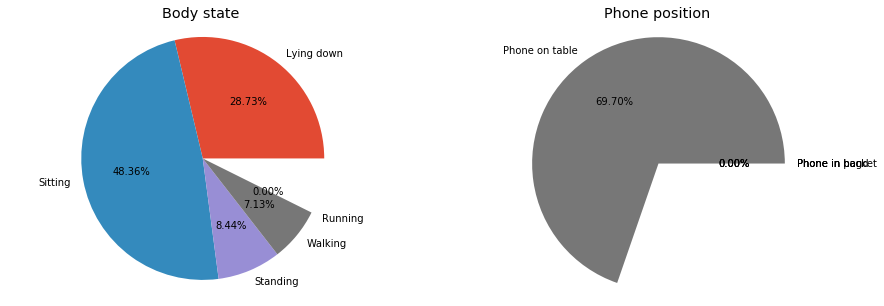

In [17]:
print("Since the collection of labels relied on self-reporting in-the-wild, the labeling may be incomplete.");
print("For instance, the users did not always report the position of the phone.");
fig = plt.figure(figsize=(15,5),facecolor='white');

ax1 = plt.subplot(1,2,1);
labels_to_display = ['LYING_DOWN','SITTING','OR_standing','FIX_walking','FIX_running'];
figure__pie_chart(Y,label_names,labels_to_display,'Body state',ax1);

ax2 = plt.subplot(1,2,2);
labels_to_display = ['PHONE_IN_HAND','PHONE_IN_BAG','PHONE_IN_POCKET','PHONE_ON_TABLE'];
figure__pie_chart(Y,label_names,labels_to_display,'Phone position',ax2);

Also, let's see label-combinations that describe specific situations.

In [62]:
def get_actual_date_labels(tick_seconds):
    import datetime;
    import pytz;
    
    time_zone = pytz.timezone('US/Pacific'); # Assuming the data comes from PST time zone
    weekday_names = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'];
    datetime_labels = [];
    for timestamp in tick_seconds:
        tick_datetime = datetime.datetime.fromtimestamp(timestamp,tz=time_zone);
        weekday_str = weekday_names[tick_datetime.weekday()];
        time_of_day = tick_datetime.strftime('%I:%M%p');
        datetime_labels.append('%s\n%s' % (weekday_str,time_of_day));
        pass;
    
    return datetime_labels;
    
def figure__context_over_participation_time(timestamps,Y,label_names,labels_to_display,label_colors,use_actual_dates=False):

    fig = plt.figure(figsize=(10,7),facecolor='white');
    ax = plt.subplot(1,1,1);
    
    seconds_in_day = (60*60*24);

    ylabels = [];
    ax.plot(timestamps,len(ylabels)*np.ones(len(timestamps)),'|',color='0.5',label='(Collected data)');
    ylabels.append('(Collected data)');

    for (li,label) in enumerate(labels_to_display):
        lind = label_names.index(label);
        is_label_on = Y[:,lind];
        label_times = timestamps[is_label_on];

        label_str = get_label_pretty_name(label);
        ax.plot(label_times,len(ylabels)*np.ones(len(label_times)),'|',color=label_colors[li],label=label_str);
        ylabels.append(label_str);
        pass;

    tick_seconds = range(timestamps[0],timestamps[-1],seconds_in_day);
    if use_actual_dates:
        tick_labels = get_actual_date_labels(tick_seconds);
        plt.xlabel('Time in San Diego',fontsize=14);
        pass;
    else:
        tick_labels = (np.array(tick_seconds - timestamps[0]).astype(float) / float(seconds_in_day)).astype(int);
        plt.xlabel('days of participation',fontsize=14);
        pass;
    
    ax.set_xticks(tick_seconds);
    ax.set_xticklabels(tick_labels,fontsize=14);

    ax.set_yticks(range(len(ylabels)));
    ax.set_yticklabels(ylabels,fontsize=14);

    ax.set_ylim([-1,len(ylabels)]);
    ax.set_xlim([min(timestamps),max(timestamps)]);
    
    return;

Here is a track of when the user was engaged in different contexts.
The bottom row (gray) states when sensors were recorded (the data-collection app was not running all the time).
The context-labels annotations were self-reported by the user (and then cleaned by the researchers).


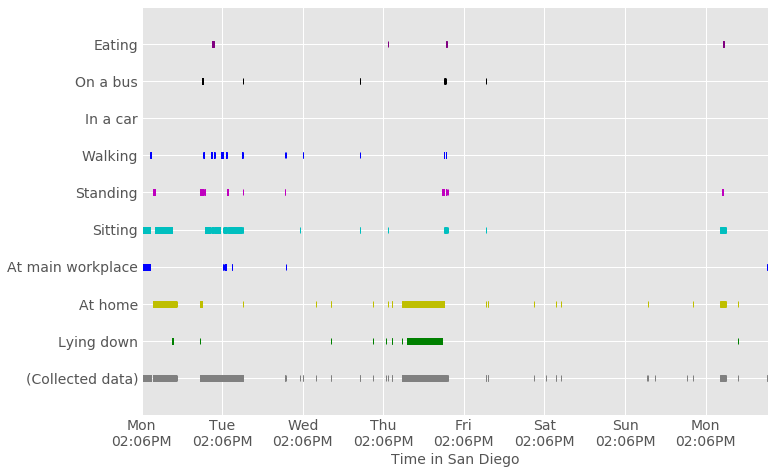

In [165]:
print("Here is a track of when the user was engaged in different contexts.");
print("The bottom row (gray) states when sensors were recorded (the data-collection app was not running all the time).");
print("The context-labels annotations were self-reported by the user (and then cleaned by the researchers).")

labels_to_display = ['LYING_DOWN','LOC_home','LOC_main_workplace','SITTING','OR_standing','FIX_walking',\
                     'IN_A_CAR','ON_A_BUS','EATING'];
label_colors = ['g','y','b','c','m','b','r','k','purple'];
figure__context_over_participation_time(timestamps,Y,label_names,labels_to_display,label_colors,use_actual_dates=True);

Sensor features:
The features are less intuitive to interpret than the labels.
They were calculated from the fuller raw-measurements from the various sensors on the smartphone or smartwatch.

We can start by looking at the feature names, where the prefix of each feature indicates the sensor where it came from.

For convenience, we add a function to parse the feature names and provide the code-name of the sensor they belong to. We'll use the code-names as they appear in the original ExtraSensory paper:
Acc (phone-accelerometer), Gyro (phone-gyroscope), WAcc (watch-accelerometer), Loc (location), Aud (audio), and PS (phone-state).
Plus, the other sensors provided here that were not analyzed in the original paper: Magnet (phone-magnetometer), Compass (watch-compass), AP (audio properties, about the overall power of the audio), and LF (various low-frequency sensors).

In [27]:
def get_sensor_names_from_features(feature_names):
    feat_sensor_names = np.array([None for feat in feature_names]);
    for (fi,feat) in enumerate(feature_names):
        if feat.startswith('raw_acc'):
            feat_sensor_names[fi] = 'Acc';
            pass;
        elif feat.startswith('proc_gyro'):
            feat_sensor_names[fi] = 'Gyro';
            pass;
        elif feat.startswith('raw_magnet'):
            feat_sensor_names[fi] = 'Magnet';
            pass;
        elif feat.startswith('watch_acceleration'):
            feat_sensor_names[fi] = 'WAcc';
            pass;
        elif feat.startswith('watch_heading'):
            feat_sensor_names[fi] = 'Compass';
            pass;
        elif feat.startswith('location'):
            feat_sensor_names[fi] = 'Loc';
            pass;
        elif feat.startswith('location_quick_features'):
            feat_sensor_names[fi] = 'Loc';
            pass;
        elif feat.startswith('audio_naive'):
            feat_sensor_names[fi] = 'Aud';
            pass;
        elif feat.startswith('audio_properties'):
            feat_sensor_names[fi] = 'AP';
            pass;
        elif feat.startswith('discrete'):
            feat_sensor_names[fi] = 'PS';
            pass;
        elif feat.startswith('lf_measurements'):
            feat_sensor_names[fi] = 'LF';
            pass;
        else:
            raise ValueError("!!! Unsupported feature name: %s" % feat);

        pass;

    return feat_sensor_names;    

In [28]:
raw_acc = []
for (fi,feat) in enumerate(feature_names):
    if feat.startswith('raw_acc'):
        raw_acc.append(feat)

In [29]:
raw_acc

['raw_acc:magnitude_stats:mean',
 'raw_acc:magnitude_stats:std',
 'raw_acc:magnitude_stats:moment3',
 'raw_acc:magnitude_stats:moment4',
 'raw_acc:magnitude_stats:percentile25',
 'raw_acc:magnitude_stats:percentile50',
 'raw_acc:magnitude_stats:percentile75',
 'raw_acc:magnitude_stats:value_entropy',
 'raw_acc:magnitude_stats:time_entropy',
 'raw_acc:magnitude_spectrum:log_energy_band0',
 'raw_acc:magnitude_spectrum:log_energy_band1',
 'raw_acc:magnitude_spectrum:log_energy_band2',
 'raw_acc:magnitude_spectrum:log_energy_band3',
 'raw_acc:magnitude_spectrum:log_energy_band4',
 'raw_acc:magnitude_spectrum:spectral_entropy',
 'raw_acc:magnitude_autocorrelation:period',
 'raw_acc:magnitude_autocorrelation:normalized_ac',
 'raw_acc:3d:mean_x',
 'raw_acc:3d:mean_y',
 'raw_acc:3d:mean_z',
 'raw_acc:3d:std_x',
 'raw_acc:3d:std_y',
 'raw_acc:3d:std_z',
 'raw_acc:3d:ro_xy',
 'raw_acc:3d:ro_xz',
 'raw_acc:3d:ro_yz']

In [30]:
feat_sensor_names = get_sensor_names_from_features(feature_names);

for (fi,feature) in enumerate(feature_names):
    print("%3d) %s %s" % (fi,feat_sensor_names[fi].ljust(10),feature));
    pass;

  0) Acc        raw_acc:magnitude_stats:mean
  1) Acc        raw_acc:magnitude_stats:std
  2) Acc        raw_acc:magnitude_stats:moment3
  3) Acc        raw_acc:magnitude_stats:moment4
  4) Acc        raw_acc:magnitude_stats:percentile25
  5) Acc        raw_acc:magnitude_stats:percentile50
  6) Acc        raw_acc:magnitude_stats:percentile75
  7) Acc        raw_acc:magnitude_stats:value_entropy
  8) Acc        raw_acc:magnitude_stats:time_entropy
  9) Acc        raw_acc:magnitude_spectrum:log_energy_band0
 10) Acc        raw_acc:magnitude_spectrum:log_energy_band1
 11) Acc        raw_acc:magnitude_spectrum:log_energy_band2
 12) Acc        raw_acc:magnitude_spectrum:log_energy_band3
 13) Acc        raw_acc:magnitude_spectrum:log_energy_band4
 14) Acc        raw_acc:magnitude_spectrum:spectral_entropy
 15) Acc        raw_acc:magnitude_autocorrelation:period
 16) Acc        raw_acc:magnitude_autocorrelation:normalized_ac
 17) Acc        raw_acc:3d:mean_x
 18) Acc        raw_acc:3d:mean_y


In [34]:
X

array([[ 0.996815,  0.003529, -0.002786, ...,  0.      ,  0.      ,
         0.      ],
       [ 0.996864,  0.004172, -0.00311 , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.996825,  0.003667,  0.003094, ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 1.002894,  0.055893,  0.084734, ...,  0.      ,  0.      ,
         0.      ],
       [ 1.002477,  0.004487, -0.0117  , ...,  0.      ,  0.      ,
         0.      ],
       [ 1.002642,  0.004171,  0.006462, ...,  0.      ,  0.      ,
         0.      ]])

In [31]:
def figure__feature_track_and_hist(X,feature_names,timestamps,feature_inds):
    seconds_in_day = (60*60*24);
    days_since_participation = (timestamps - timestamps[0]) / float(seconds_in_day);
    
    for ind in feature_inds:
        feature = feature_names[ind];
        feat_values = X[:,ind];
        
        fig = plt.figure(figsize=(10,3),facecolor='white');
        
        ax1 = plt.subplot(1,2,1);
        ax1.plot(days_since_participation,feat_values,'.-',markersize=3,linewidth=0.1);
        plt.xlabel('days of participation');
        plt.ylabel('feature value');
        plt.title('%d) %s\nfunction of time' % (ind,feature));
        
        ax1 = plt.subplot(1,2,2);
        existing_feature = np.logical_not(np.isnan(feat_values));
        ax1.hist(feat_values[existing_feature],bins=30);
        plt.xlabel('feature value');
        plt.ylabel('count');
        plt.title('%d) %s\nhistogram' % (ind,feature));
        
        pass;
    
    return;

In [32]:
# plt.style.use('ggplot')

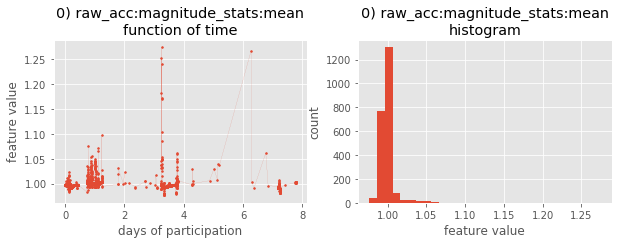

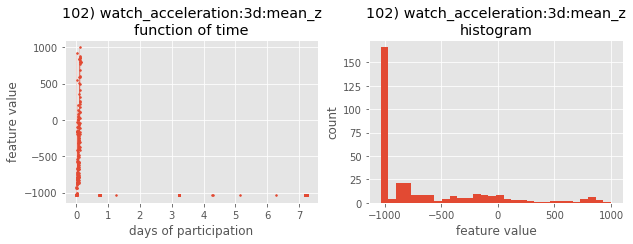

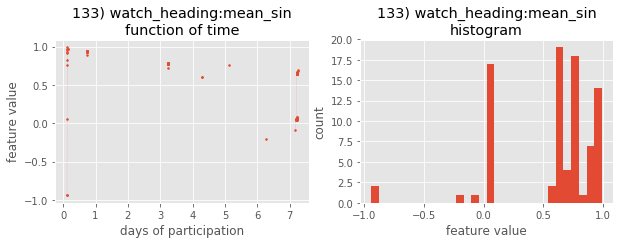

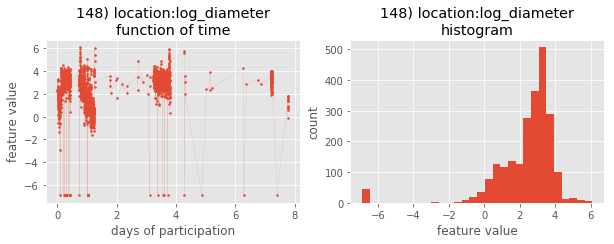

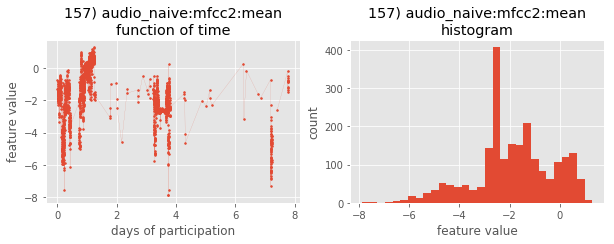

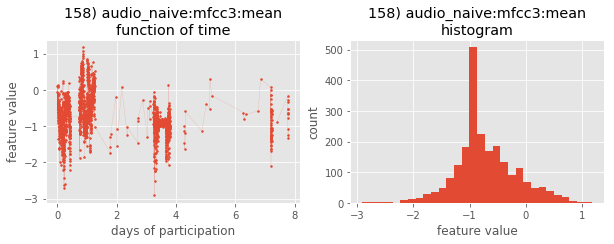

In [33]:
feature_inds = [0,102,133,148,157,158];
figure__feature_track_and_hist(X,feature_names,timestamps,feature_inds);

====================================================================================================

Relation between sensor-features and context-label.
We can start looking into how the sensor-feature values correspond to different context labels:

In [134]:
def figure__feature_scatter_for_labels(X,Y,feature_names,label_names,feature1,feature2,label2color_map):
    feat_ind1 = feature_names.index(feature1);
    feat_ind2 = feature_names.index(feature2);
    example_has_feature1 = np.logical_not(np.isnan(X[:,feat_ind1]));
    example_has_feature2 = np.logical_not(np.isnan(X[:,feat_ind2]));
    example_has_features12 = np.logical_and(example_has_feature1,example_has_feature2);
    
    fig = plt.figure(figsize=(12,5),facecolor='white');
    ax1 = plt.subplot(1,2,1);
    ax2 = plt.subplot(2,2,2);
    ax3 = plt.subplot(2,2,4);
    
    for label in label2color_map.keys():
        label_ind = label_names.index(label);
        pretty_name = get_label_pretty_name(label);
        color = label2color_map[label];
        style = '.%s' % color;
        
        is_relevant_example = np.logical_and(example_has_features12,Y[:,label_ind]);
        count = sum(is_relevant_example);
        feat1_vals = X[is_relevant_example,feat_ind1];
        feat2_vals = X[is_relevant_example,feat_ind2];
        ax1.plot(feat1_vals,feat2_vals,style,markersize=5,label=pretty_name);
        
        ax2.hist(X[is_relevant_example,feat_ind1],bins=20,normed=True,color=color,alpha=0.5,label='%s (%d)' % (pretty_name,count));
        ax3.hist(X[is_relevant_example,feat_ind2],bins=20,normed=True,color=color,alpha=0.5,label='%s (%d)' % (pretty_name,count));
        pass;
    
    ax1.set_xlabel(feature1);
    ax1.set_ylabel(feature2);
    
    ax2.set_title(feature1);
    ax3.set_title(feature2);
    
    ax2.legend(loc='best');
    
    return;

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


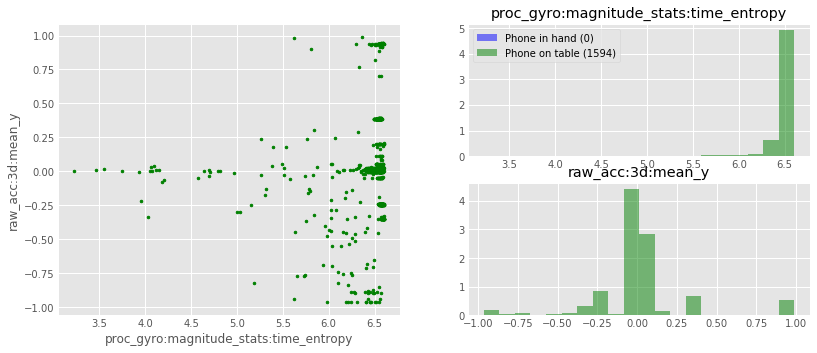

In [135]:
feature1 = 'proc_gyro:magnitude_stats:time_entropy';#raw_acc:magnitude_autocorrelation:period';
feature2 = 'raw_acc:3d:mean_y';
label2color_map = {'PHONE_IN_HAND':'b','PHONE_ON_TABLE':'g'};
figure__feature_scatter_for_labels(X,Y,feature_names,label_names,feature1,feature2,label2color_map);

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


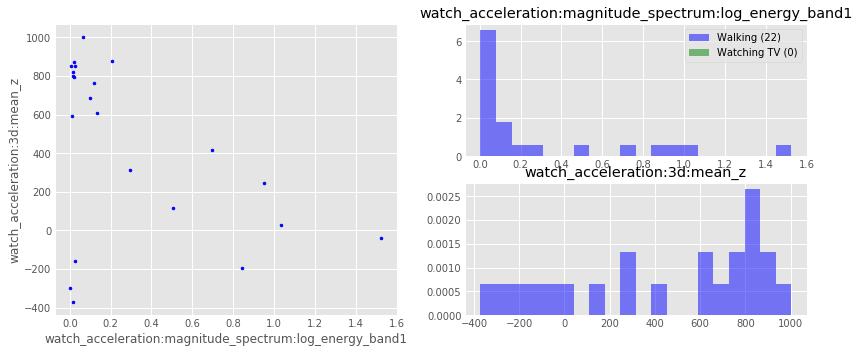

In [136]:
feature1 = 'watch_acceleration:magnitude_spectrum:log_energy_band1';
feature2 = 'watch_acceleration:3d:mean_z';
label2color_map = {'FIX_walking':'b','WATCHING_TV':'g'};
figure__feature_scatter_for_labels(X,Y,feature_names,label_names,feature1,feature2,label2color_map);

In [137]:
import sklearn.linear_model;

def project_features_to_selected_sensors(X,feat_sensor_names,sensors_to_use):
    use_feature = np.zeros(len(feat_sensor_names),dtype=bool);
    for sensor in sensors_to_use:
        is_from_sensor = (feat_sensor_names == sensor);
        use_feature = np.logical_or(use_feature,is_from_sensor);
        pass;
    X = X[:,use_feature];
    return X;

def estimate_standardization_params(X_train):
    mean_vec = np.nanmean(X_train,axis=0);
    std_vec = np.nanstd(X_train,axis=0);
    return (mean_vec,std_vec);

def standardize_features(X,mean_vec,std_vec):
    # Subtract the mean, to centralize all features around zero:
    X_centralized = X - mean_vec.reshape((1,-1));
    # Divide by the standard deviation, to get unit-variance for all features:
    # * Avoid dividing by zero, in case some feature had estimate of zero variance
    normalizers = np.where(std_vec > 0., std_vec, 1.).reshape((1,-1));
    X_standard = X_centralized / normalizers;
    return X_standard;

def train_model(X_train,Y_train,M_train,feat_sensor_names,label_names,sensors_to_use,target_label):
    # Project the feature matrix to the features from the desired sensors:
    X_train = project_features_to_selected_sensors(X_train,feat_sensor_names,sensors_to_use);
    print("== Projected the features to %d features from the sensors: %s" % (X_train.shape[1],', '.join(sensors_to_use)));

    # It is recommended to standardize the features (subtract mean and divide by standard deviation),
    # so that all their values will be roughly in the same range:
    (mean_vec,std_vec) = estimate_standardization_params(X_train);
    X_train = standardize_features(X_train,mean_vec,std_vec);
    
    # The single target label:
    label_ind = label_names.index(target_label);
    y = Y_train[:,label_ind];
    missing_label = M_train[:,label_ind];
    existing_label = np.logical_not(missing_label);
    
    # Select only the examples that are not missing the target label:
    X_train = X_train[existing_label,:];
    y = y[existing_label];
    
    # Also, there may be missing sensor-features (represented in the data as NaN).
    # You can handle those by imputing a value of zero (since we standardized, this is equivalent to assuming average value).
    # You can also further select examples - only those that have values for all the features.
    # For this tutorial, let's use the simple heuristic of zero-imputation:
    X_train[np.isnan(X_train)] = 0.;
    
    print("== Training with %d examples. For label '%s' we have %d positive and %d negative examples." % \
          (len(y),get_label_pretty_name(target_label),sum(y),sum(np.logical_not(y))) );
    
    # Now, we have the input features and the ground truth for the output label.
    # We can train a logistic regression model.
    
    # Typically, the data is highly imbalanced, with many more negative examples;
    # To avoid a trivial classifier (one that always declares 'no'), it is important to counter-balance the pos/neg classes:
    lr_model = sklearn.linear_model.LogisticRegression(class_weight='balanced');
    lr_model.fit(X_train,y);
    
    # Assemble all the parts of the model:
    model = {\
            'sensors_to_use':sensors_to_use,\
            'target_label':target_label,\
            'mean_vec':mean_vec,\
            'std_vec':std_vec,\
            'lr_model':lr_model};
    
    return model;

In [138]:
sensors_to_use = ['Acc','WAcc'];
target_label = 'FIX_walking';
model = train_model(X,Y,M,feat_sensor_names,label_names,sensors_to_use,target_label);

== Projected the features to 72 features from the sensors: Acc, WAcc
== Training with 2119 examples. For label 'Walking' we have 163 positive and 1956 negative examples.


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Testing.
Now we can evaluate the quality of the classifier.
Let's test the predictions it makes on the user:

In [139]:
def test_model(X_test,Y_test,M_test,timestamps,feat_sensor_names,label_names,model):
    # Project the feature matrix to the features from the sensors that the classifier is based on:
    X_test = project_features_to_selected_sensors(X_test,feat_sensor_names,model['sensors_to_use']);
    print("== Projected the features to %d features from the sensors: %s" % (X_test.shape[1],', '.join(model['sensors_to_use'])));

    # We should standardize the features the same way the train data was standardized:
    X_test = standardize_features(X_test,model['mean_vec'],model['std_vec']);
    
    # The single target label:
    label_ind = label_names.index(model['target_label']);
    y = Y_test[:,label_ind];
    missing_label = M_test[:,label_ind];
    existing_label = np.logical_not(missing_label);
    
    # Select only the examples that are not missing the target label:
    X_test = X_test[existing_label,:];
    y = y[existing_label];
    timestamps = timestamps[existing_label];

    # Do the same treatment for missing features as done to the training data:
    X_test[np.isnan(X_test)] = 0.;
    
    print("== Testing with %d examples. For label '%s' we have %d positive and %d negative examples." % \
          (len(y),get_label_pretty_name(target_label),sum(y),sum(np.logical_not(y))) );
    
    # Preform the prediction:
    y_pred = model['lr_model'].predict(X_test);
    
    # Naive accuracy (correct classification rate):
    accuracy = np.mean(y_pred == y);
    
    # Count occorrences of true-positive, true-negative, false-positive, and false-negative:
    tp = np.sum(np.logical_and(y_pred,y));
    tn = np.sum(np.logical_and(np.logical_not(y_pred),np.logical_not(y)));
    fp = np.sum(np.logical_and(y_pred,np.logical_not(y)));
    fn = np.sum(np.logical_and(np.logical_not(y_pred),y));
    
    # Sensitivity (=recall=true positive rate) and Specificity (=true negative rate):
    sensitivity = float(tp) / (tp+fn);
    specificity = float(tn) / (tn+fp);
    
    # Balanced accuracy is a more fair replacement for the naive accuracy:
    balanced_accuracy = (sensitivity + specificity) / 2.;
    
    # Precision:
    # Beware from this metric, since it may be too sensitive to rare labels.
    # In the ExtraSensory Dataset, there is large skew among the positive and negative classes,
    # and for each label the pos/neg ratio is different.
    # This can cause undesirable and misleading results when averaging precision across different labels.
    precision = float(tp) / (tp+fp);
    
    print("-"*10);
    print('Accuracy*:         %.2f' % accuracy);
    print('Sensitivity (TPR): %.2f' % sensitivity);
    print('Specificity (TNR): %.2f' % specificity);
    print('Balanced accuracy: %.2f' % balanced_accuracy);
    print('Precision**:       %.2f' % precision);
    print("-"*10);
    
    print('* The accuracy metric is misleading - it is dominated by the negative examples (typically there are many more negatives).')
    print('** Precision is very sensitive to rare labels. It can cause misleading results when averaging precision over different labels.')
    
    fig = plt.figure(figsize=(10,4),facecolor='white');
    ax = plt.subplot(1,1,1);
    ax.plot(timestamps[y],1.4*np.ones(sum(y)),'|g',markersize=10,label='ground truth');
    ax.plot(timestamps[y_pred],np.ones(sum(y_pred)),'|b',markersize=10,label='prediction');
    
    seconds_in_day = (60*60*24);
    tick_seconds = range(timestamps[0],timestamps[-1],seconds_in_day);
    tick_labels = (np.array(tick_seconds - timestamps[0]).astype(float) / float(seconds_in_day)).astype(int);
    
    ax.set_ylim([0.5,5]);
    ax.set_xticks(tick_seconds);
    ax.set_xticklabels(tick_labels);
    plt.xlabel('days of participation',fontsize=14);
    ax.legend(loc='best');
    plt.title('%s\nGround truth vs. predicted' % get_label_pretty_name(model['target_label']));
    
    return;

== Projected the features to 72 features from the sensors: Acc, WAcc
== Testing with 2119 examples. For label 'Walking' we have 163 positive and 1956 negative examples.
----------
Accuracy*:         0.88
Sensitivity (TPR): 0.83
Specificity (TNR): 0.88
Balanced accuracy: 0.86
Precision**:       0.37
----------
* The accuracy metric is misleading - it is dominated by the negative examples (typically there are many more negatives).
** Precision is very sensitive to rare labels. It can cause misleading results when averaging precision over different labels.


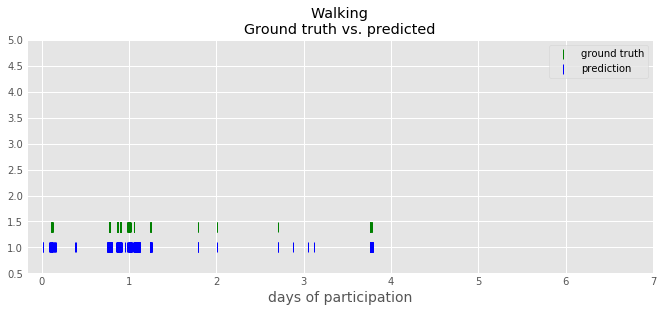

In [140]:
test_model(X,Y,M,timestamps,feat_sensor_names,label_names,model);

Let's test the same model on data of another user:

In [157]:
def validate_column_names_are_consistent(old_column_names,new_column_names):
    if len(old_column_names) != len(new_column_names):
        raise ValueError("!!! Inconsistent number of columns.");
        
    for ci in range(len(old_column_names)):
        if old_column_names[ci] != new_column_names[ci]:
            raise ValueError("!!! Inconsistent column %d) %s != %s" % (ci,old_column_names[ci],new_column_names[ci]));
        pass;
    return;

In [161]:
uuid = '1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842';
(X2,Y2,M2,timestamps2,feature_names2,label_names2) = read_user_data(uuid);

# All the user data files should have the exact same columns. We can validate it:
validate_column_names_are_consistent(feature_names,feature_names2);
validate_column_names_are_consistent(label_names,label_names2);

In [162]:
X2,Y2,M2

(array([[ 9.781190e-01,  2.341000e-03,  2.273000e-03, ...,  1.000000e+00,
          0.000000e+00,  0.000000e+00],
        [ 9.783150e-01,  1.636000e-03,  5.100000e-04, ...,  1.000000e+00,
          0.000000e+00,  0.000000e+00],
        [ 9.785820e-01,  2.582000e-03, -2.260000e-03, ...,  1.000000e+00,
          0.000000e+00,  0.000000e+00],
        ...,
        [ 1.014174e+00,  9.640000e-04, -3.070000e-04, ...,  0.000000e+00,
          0.000000e+00,  0.000000e+00],
        [ 1.014009e+00,  1.029000e-03, -2.930000e-04, ...,  0.000000e+00,
          0.000000e+00,  0.000000e+00],
        [ 1.014237e+00,  9.960000e-04,  4.760000e-04, ...,  0.000000e+00,
          0.000000e+00,  0.000000e+00]]),
 array([[False,  True, False, ..., False, False, False],
        [False,  True, False, ..., False, False, False],
        [False,  True, False, ..., False, False, False],
        ...,
        [ True, False, False, ...,  True, False, False],
        [ True, False, False, ...,  True, False, False],
   

== Projected the features to 72 features from the sensors: Acc, WAcc
== Testing with 7192 examples. For label 'Walking' we have 925 positive and 6267 negative examples.
----------
Accuracy*:         0.64
Sensitivity (TPR): 0.58
Specificity (TNR): 0.65
Balanced accuracy: 0.61
Precision**:       0.19
----------
* The accuracy metric is misleading - it is dominated by the negative examples (typically there are many more negatives).
** Precision is very sensitive to rare labels. It can cause misleading results when averaging precision over different labels.


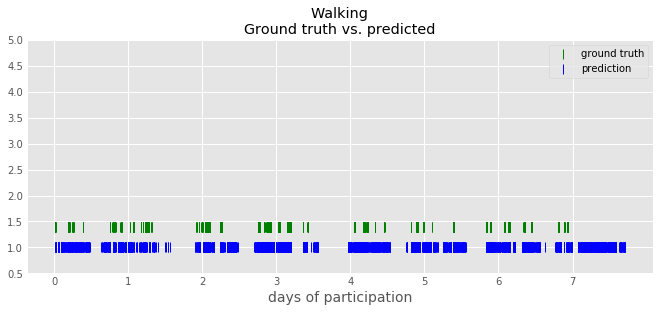

In [163]:
test_model(X2,Y2,M2,timestamps2,feat_sensor_names,label_names,model);

As expected, prediction over a new user is harder.

In our papers, we perform 5-fold cross validation evaluation: for each fold training on data from 4/5 of the users and testing on the remaining 1/5 of the users.
We also provide files with the same partition (of 60 users to 5 folds) that we used.